In [1]:
from edgedroid.models.timings import *

runs_per_model = 30
task_steps = 100

neuroticism = 1.0
fade_dist = 8

models = {
    "empirical": EmpiricalExecutionTimeModel.from_default_data(neuroticism=neuroticism, transition_fade_distance=fade_dist),
    "theoretical": TheoreticalExecutionTimeModel.from_default_data(neuroticism=neuroticism, transition_fade_distance=fade_dist),
    "constant": ConstantExecutionTimeModel.from_default_data(),
    "naive": NaiveExecutionTimeModel.from_default_data(),
    "fitted-naive": FittedNaiveExecutionTimeModel.from_default_data(),
}

In [2]:
import numpy as np

ttfs = np.linspace(0, 7, 50)
ttfs

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        , 1.14285714, 1.28571429,
       1.42857143, 1.57142857, 1.71428571, 1.85714286, 2.        ,
       2.14285714, 2.28571429, 2.42857143, 2.57142857, 2.71428571,
       2.85714286, 3.        , 3.14285714, 3.28571429, 3.42857143,
       3.57142857, 3.71428571, 3.85714286, 4.        , 4.14285714,
       4.28571429, 4.42857143, 4.57142857, 4.71428571, 4.85714286,
       5.        , 5.14285714, 5.28571429, 5.42857143, 5.57142857,
       5.71428571, 5.85714286, 6.        , 6.14285714, 6.28571429,
       6.42857143, 6.57142857, 6.71428571, 6.85714286, 7.        ])

In [3]:
import pandas as pd

results = pd.DataFrame(
    columns=["model", "repetition", "step", "exec_time", "ttf", "duration", "cumulative_duration"],
    index=np.arange(0, len(models) * ttfs.size * runs_per_model * task_steps)
)

results.shape

(750000, 7)

In [4]:
from tqdm.notebook import tqdm_notebook as tqdm
import itertools as it

curr_idx = 0

combs = list(it.product(
    models.items(),
    ttfs,
    range(1, runs_per_model + 1),
))


tqdm_iter = tqdm(combs)

for (model_name, model), ttf, repetition in tqdm_iter:
    tqdm_iter.set_description(
        desc=f"Model {model_name}, TTF {ttf:0.02f}s, repetition {repetition}"
    )
    cum_duration = 0.0

    for step in range(1, task_steps + 1):
        exec_time = model.advance(ttf).get_execution_time()
        duration = exec_time + ttf
        cum_duration += duration

        results.at[curr_idx, "model"] = model_name
        results.at[curr_idx, "repetition"] = repetition
        results.at[curr_idx, "step"] = step
        results.at[curr_idx, "exec_time"] = exec_time
        results.at[curr_idx, "ttf"] = ttf
        results.at[curr_idx, "duration"] = duration
        results.at[curr_idx, "cumulative_duration"] = cum_duration

        curr_idx += 1


results["model"] = results["model"].astype("category")
results["repetition"] = results["repetition"].astype(int)
results["step"] = results["step"].astype(int)
results["exec_time"] = results["exec_time"].astype(float)
results["ttf"] = results["ttf"].astype(float)
results["duration"] = results["duration"].astype(float)
results["cumulative_duration"] = results["cumulative_duration"].astype(float)
results

  0%|          | 0/7500 [00:00<?, ?it/s]

,model,repetition,step,exec_time,ttf,duration,cumulative_duration
0,empirical,1,1,2.543611,0.0,2.543611,2.543611
1,empirical,1,2,7.487442,0.0,7.487442,10.031053
2,empirical,1,3,6.984446,0.0,6.984446,17.015499
3,empirical,1,4,6.260453,0.0,6.260453,23.275952
4,empirical,1,5,5.184276,0.0,5.184276,28.460229
...,...,...,...,...,...,...,...
749995,fitted-naive,30,96,6.549949,7.0,13.549949,1217.498790
749996,fitted-naive,30,97,6.334340,7.0,13.334340,1230.833129
749997,fitted-naive,30,98,6.604814,7.0,13.604814,1244.437943
749998,fitted-naive,30,99,3.989545,7.0,10.989545,1255.427488


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_style("whitegrid")

end_steps = results[results.step == results.step.max()]
end_steps

,model,repetition,step,exec_time,ttf,duration,cumulative_duration
99,empirical,1,100,7.734432,0.0,7.734432,461.527767
199,empirical,2,100,11.294814,0.0,11.294814,491.583308
299,empirical,3,100,2.516810,0.0,2.516810,495.389467
399,empirical,4,100,4.031567,0.0,4.031567,485.101807
499,empirical,5,100,2.755791,0.0,2.755791,440.536254
...,...,...,...,...,...,...,...
749599,fitted-naive,26,100,3.615777,7.0,10.615777,1274.176894
749699,fitted-naive,27,100,3.231286,7.0,10.231286,1259.493725
749799,fitted-naive,28,100,7.396271,7.0,14.396271,1300.030830
749899,fitted-naive,29,100,4.956692,7.0,11.956692,1275.521622


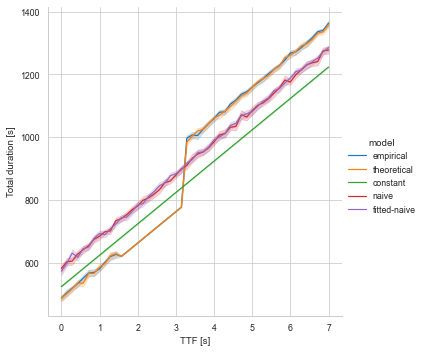

In [12]:
fg = sns.relplot(
    kind="line",
    data=end_steps,
    x="ttf",
    y="cumulative_duration",
    hue="model",
    hue_order=["empirical", "theoretical", "constant", "naive", "fitted-naive"],
)
fg.set_axis_labels("TTF [s]", "Total duration [s]")
plt.show()

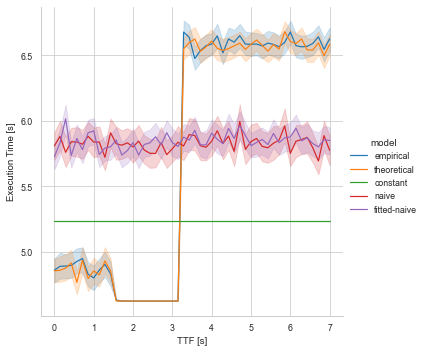

In [15]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "constant", "naive", "fitted-naive"],
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()